In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import numpy as np


In [2]:
test_image='../test_images/test1.jpg'

Image size: (720, 1280, 3)


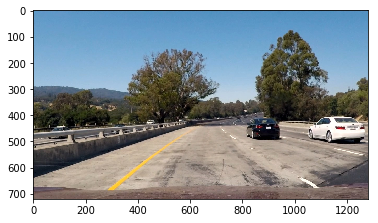

In [3]:
image=cv2.cvtColor(cv2.imread(test_image),cv2.COLOR_BGR2RGB)
plt.imshow(image)
print("Image size: {}".format(image.shape))

Scale down the image by 4


New image size: (180, 320, 3)


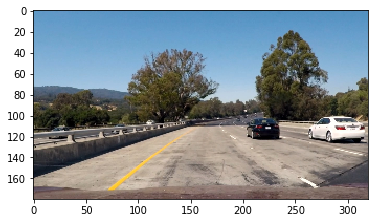

In [4]:
image_scaled=cv2.resize(image,None,fx=0.25,fy=0.25)
plt.imshow(image_scaled)
print("New image size: {}".format(image_scaled.shape))

As we can see from above image, this looks large enough to run the vehicle detection

Set the top and bottom threshold:

In [5]:
detection_area=((0,90),(319,159))

Show the threshold rectangle

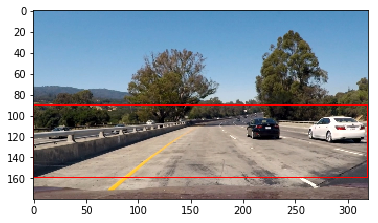

In [6]:
detection_rect=np.copy(image_scaled)
plt.imshow(cv2.rectangle(detection_rect,detection_area[0],detection_area[1], color=(255,0,0),thickness=1))

32x32 Image Windows

In [7]:
# 50% overlap b/n windows
overlap=0.5

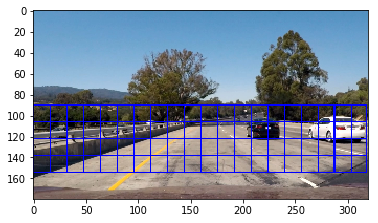

In [8]:
windows_32=np.copy(image_scaled)
for row in range(detection_area[0][1],image_scaled.shape[0],int(32*overlap)):
    if(row+32 < detection_area[1][1]): #if window border is less than ROI
        for col in range(detection_area[0][0],image_scaled.shape[1],int(32*overlap)):
            if(col+32 < detection_area[1][0]):
                cv2.rectangle(windows_32,(col,row),(col+32,row+32),(0,0,255),1)
            elif(col+32 > overlap*32): # Handle the last portion in width
                cv2.rectangle(windows_32,(detection_area[1][0]-32,row),(detection_area[1][0]-1,row+32),(0,0,255),1)
plt.imshow(windows_32)

Observing the image above, we can assume that cars far away look smaller and the close ones look larger.

Likewise, we can set different thresholds for 32x32, 64x64  windows

In [9]:
overlap=0.5
window_sizes=[32,64]
slide_thresholds=[(85,85+int(3*32/2)),(85,85+int(1*64/2))]


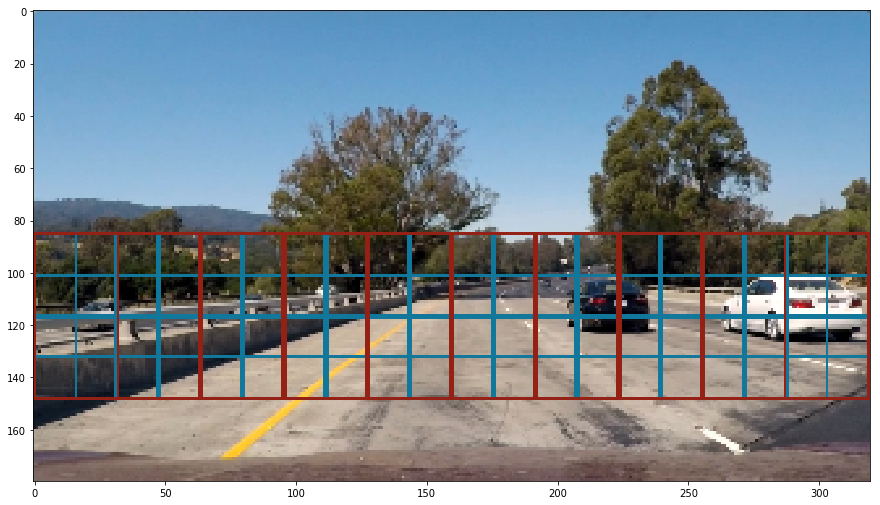

In [10]:
windows=np.copy(image_scaled)
windos_rects=[]
for i in range(len(window_sizes)):
    window_size = window_sizes[i]
    color=np.random.randint(0,255,size=(3,)).astype(np.float64)
    for row in range(slide_thresholds[i][0],slide_thresholds[i][1],int(window_size*overlap)):
        for col in range(0,image_scaled.shape[1]-window_size,int(window_size*overlap)):
            cv2.rectangle(windows,(col,row),(col+window_size-1,row+window_size-1),color,thickness=1)
            windos_rects.append(((col,row),(col+window_size-1,row+window_size-1)))
#         Handle the last window column
        cv2.rectangle(windows,(image_scaled.shape[1]-window_size,row),(image_scaled.shape[1]-1,row+window_size-1),color,1)
        windos_rects.append(((image_scaled.shape[1]-window_size,row),(image_scaled.shape[1]-1,row+window_size-1)))
fig=plt.figure(figsize=(15,10))
plt.imshow(windows)

Run SVM on windows

In [11]:
from sklearn import svm
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

In [12]:
model=joblib.load('model_svm.pkl')
scaler=joblib.load('stdscaler.pkl')

In [13]:
from skimage.feature import hog
def get_features(img,cell_per_block=2,pix_per_cell=8,orient=9, colorspace='HSV', color_hist_bins=16, img_resize=(32,32)):
#     returns the feature vector for the image
    if(img_resize != (img.shape[0]),img.shape[1]):
        img=cv2.resize(img,img_resize)
#     get hog features before colorspace conversion
    feat=hog(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=True)
#     Convert to required colorspace
    if(colorspace!='BGR'):
        if(colorspace=='HSV'):
            img=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif(colorspace=='HLS'):
            img=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        else:
            pass    
    for i in range(3):
#         loop over three channels
        ch_hist = np.histogram(img[:,:,i],bins=color_hist_bins,range=(0,256))[0]
        feat = np.concatenate((feat,ch_hist))
    return feat

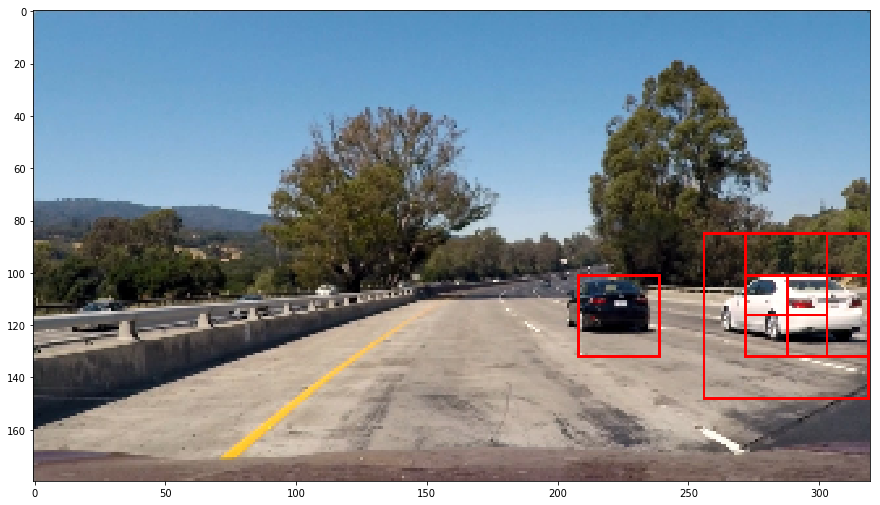

In [18]:
test_image='../test_images/test6.jpg'
cv2.cvtColor(cv2.imread(test_image),cv2.COLOR_BGR2RGB)
image_scaled=cv2.resize(image,None,fx=0.25,fy=0.25)

detection_image=np.copy(image_scaled)

for _win in windos_rects:
    _img=np.copy(image_scaled[_win[0][1]:_win[1][1]+1, _win[0][0]:_win[1][0]+1,:])
#     Get the features
    _feats=scaler.transform(get_features(_img).reshape(1,-1))
    pred=model.predict(_feats.reshape(1,-1))
    if pred == 1:
        cv2.rectangle(detection_image,_win[0],_win[1],(255,0,0),1)
fig=plt.figure(figsize=(15,10))
plt.imshow(detection_image)

In [19]:
# Process Video func
def process_video(frame):
#     Assumes RGB frame:
    image_scaled=cv2.resize(frame,(320,180))
    detection_image=np.copy(image_scaled)
    for _win in windos_rects:
        _img=np.copy(image_scaled[_win[0][1]:_win[1][1]+1, _win[0][0]:_win[1][0]+1,:])
    #     Get the features
        _feats=scaler.transform(get_features(_img).reshape(1,-1))
        pred=model.predict(_feats.reshape(1,-1))
        if pred == 1:
            cv2.rectangle(detection_image,_win[0],_win[1],(255,0,0),1)
    return detection_image

In [26]:
# Test on video;
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
out_file="video_test.mp4"
%time white_clip.write_videofile(out_file, audio=False)


[MoviePy] >>>> Building video video_test.mp4
[MoviePy] Writing video video_test.mp4


100%|█████████▉| 1260/1261 [01:24<00:00, 15.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: video_test.mp4 

CPU times: user 1min 23s, sys: 684 ms, total: 1min 24s
Wall time: 1min 24s


In [27]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_file))